In [372]:
import sys
import os 
%load_ext autoreload
%autoreload 2

os.chdir("/home/cooper-cooper/Desktop/vans/")

sys.path[0] = "/home/cooper-cooper/Desktop/vans/"


from utilities.variational import Autoencoder
import tensorflow_quantum as tfq
from utilities.qmodels import QNN,EnergyLoss

import tensorflow as tf

from utilities.evaluator import Evaluator
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
from utilities.variational import VQE
import cirq

from datetime import datetime

from utilities.variational import VQE
from utilities.evaluator import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer_autoencoder import UnitaryMurder
from utilities.misc import scheduler_selector_temperature, scheduler_parameter_perturbation_wall #this outputs always 10 for now.



### load pure states

indexed_pure_states=[]
resolver_pure_states=[]
js=np.linspace(0.5,2.3,16)[0::3]
for bond in js:
    problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., bond))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
    args={"n_qubits":8,"problem_config":problem_config, "load_displaying":False,"specific_folder_name":"4_bd_{}".format(bond)}
    evaluator = Evaluator(args,loading=True, path="../data-vans/data-in-paper-2marzo/")
    #energies.append(evaluator.raw_history[len(list(evaluator.raw_history.keys()))-1][-1])
    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True)
    _, cuener, indexed_circuit, resolver, bestener = evaluator.evolution[evaluator.get_best_iteration()]
    indexed_pure_states.append(indexed_circuit)
    resolver_pure_states.append(resolver)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [376]:

auto_handler = Autoencoder(n_qubits=4,problem_config=problem_config, nb=3, lr = 0.01,
                        epochs=5000, verbose=0,
                        patience=500, optimizer="adam",
                        many_indexed_circuits=indexed_pure_states, many_symbols_to_values=resolver_pure_states)

evaluator = Evaluator(args={"n_qubits":4,
                            "problem_config":{"problem":"AutoencoderH2","n_qubits":3},
                            "noise_config":{}},
                      info="", 
                      path="../data-vans/", acceptance_percentage=1e-4,
                      accuracy_to_end=0., reduce_acceptance_percentage=True)

info = "AUTOENCODEr\ntotal_qubits: {}\ntrash_qubits: {}\n".format(len(auto_handler.qubits), auto_handler.nb)
evaluator.displaying["information"]+=info


start = datetime.now()

initialization="hea"

selector_temperature=20
reps=50
rate_iids_per_step=1.5
wait_to_get_back=10

iid = IdInserter(n_qubits=len(auto_handler.qubits))
iid.selector_temperature = selector_temperature

#Simplifier reduces gates number as much as possible while keeping same expected value of target hamiltonian
Simp = Simplifier(n_qubits=len(auto_handler.qubits))

#UnitaryMuerder is in charge of evaluating changes on the energy while setting apart one (or more) parametrized gates. If
killer = UnitaryMurder(auto_handler, many_indexed_circuits=indexed_pure_states, many_symbols_to_values=resolver_pure_states, noise_config={}, accept_wall=1e-5)

#indexed_circuit = auto_handler.hea_ansatz_indexed_circuit(L=8)
inexed_circuit = [auto_handler.number_of_cnots+k for k in range(auto_handler.n_qubits,2*vqe_handler.n_qubits)]
print("beggining to train!")
energy, symbol_to_value, training_evolution = auto_handler.autoencoder(indexed_circuit) #compute energy
#add initial info to evaluator


to_print="\nIteration #{}\nTime since beggining:{}\n best energy: {}\ncurrent_energy {}\n lower_bound: {}".format(0, datetime.now()-start, energy, energy, evaluator.accuracy_to_end)
print(to_print)
evaluator.displaying["information"]+=to_print

evaluator.add_step(indexed_circuit, symbol_to_value, energy, relevant=True)
evaluator.lowest_energy = energy

for iteration in range(1,reps+1):
    relevant=False

    ### create a mutation M (maybe this word is too fancy); we add (probably more than one) identity resolution
    iid.selector_temperature=scheduler_selector_temperature(energy, evaluator.lowest_energy, when_on=selector_temperature)
    M_indices, M_symbols_to_values, M_idx_to_symbols = iid.place_identities(indexed_circuit, symbol_to_value, rate_iids_per_step= rate_iids_per_step)

    ### simplify the circuit as much as possible
    Sindices, Ssymbols_to_values, Sindex_to_symbols = Simp.reduce_circuit(M_indices, M_symbols_to_values, M_idx_to_symbols)

    ## compute the energy of the mutated-simplified circuit [Note 1]
    MSenergy, MSsymbols_to_values, _ = auto_handler.autoencoder(
        Sindices, symbols_to_values=Ssymbols_to_values,
        parameter_perturbation_wall=scheduler_parameter_perturbation_wall(its_without_improvig=evaluator.its_without_improvig))

    if evaluator.accept_energy(MSenergy):
        indexed_circuit, symbol_to_value, index_to_symbols = Sindices, MSsymbols_to_values, Sindex_to_symbols
        # unitary slaughter: delete as many 1-qubit gates as possible, as long as the energy doesn't go up (we allow %1 increments per iteration)
        cnt=0
        reduced=True
        lmax=len(indexed_circuit)
        while reduced and cnt < lmax:
            indexed_circuit, symbol_to_value, index_to_symbols, energy, reduced = killer.unitary_slaughter(indexed_circuit, symbol_to_value, index_to_symbols, reference_energy=MSenergy)
            indexed_circuit, symbol_to_value, index_to_symbols = Simp.reduce_circuit(indexed_circuit, symbol_to_value, index_to_symbols)
            cnt+=1
        relevant=True
    evaluator.add_step(indexed_circuit, symbol_to_value, energy, relevant=relevant)

    to_print="\nIteration #{}\nTime since beggining:{}\n best energy: {}\ncurrent energy: {}\n lower_bound: {}".format(iteration, datetime.now()-start, evaluator.lowest_energy,energy, evaluator.accuracy_to_end)
    print(to_print)
    evaluator.displaying["information"]+=to_print

    evaluator.save_dicts_and_displaying()

    if evaluator.if_finish_ok is True:
        print("HOMEWORK DONE! \nBeers on me ;)")
        break

    if evaluator.its_without_improvig == wait_to_get_back:
        print("Getting back to favorite, it's been already {} iterations".format(wait_to_get_back))
        _, energy, indices, resolver, _, _ =  evaluator.evolution[evaluator.get_best_iteration()]
        evaluator.its_without_improvig = 0


beggining to train!

Iteration #0
Time since beggining:0:00:57.587375
 best energy: 0.010405004024505615
current_energy 0.010405004024505615
 lower_bound: 0.0
I killed 1 unitaries, Ef - Ei: -5.364418029785156e-07
I killed 2 unitaries, Ef - Ei: -5.364418029785156e-07
I killed 3 unitaries, Ef - Ei: -5.364418029785156e-07
I killed 4 unitaries, Ef - Ei: -5.364418029785156e-07
I killed 5 unitaries, Ef - Ei: -3.5762786865234375e-07
I killed 6 unitaries, Ef - Ei: 0.0
I killed 7 unitaries, Ef - Ei: 0.0004055500030517578


KeyboardInterrupt: 

Now we construct the inverse circuit.

Let's say that VQE-VAns prepares the state $| \psi_i >$ as $V_i |0>$. Then VAns finds an autoencoder circuit $W$.

Then we'll check at the average fidelity $\sum_i |<\psi_i| \tilde{\psi}_i> |^{2}$

with  $|\tilde{\psi}_i> = (\mathcal{E} \circ \mathcal{M} \circ \mathcal{D}) \; |\psi_i>$; 

with $\mathcal{E} = W$, $\mathcal{D} = W^{\dagger}$ and $\mathcal{M} = \mathcal{I}_{AB} - \dfrac{1}{n_B} ( \sum_j |0>_{j_B}<0| \times \mathcal{I}_{A, \bar{j}})$

In [253]:
W, cost, indexed_circuit, resolver, best_infidelity,_ = evaluator.evolution[evaluator.get_best_iteration()]

inverse_indexed_circuit, inversolver, Wdagger = auto_handler.give_inverse(indexed_circuit,resolver)
Wdagger = cirq.unitary(Wdagger)

In [254]:

def compute_fidelity(input_state, encoding, channel, decoding):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.round(np.dot(np.conjugate(input_state),st), 16)

def compute_energy(input_state, encoding, channel, decoding, observable):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.dot(np.conjugate(st),np.dot(observable,st))


In [266]:
auto_handler.observable[0].dense(auto_handler.qubits)

AttributeError: 'PauliSum' object has no attribute 'dense'

In [265]:
sum(auto_handler.observable).matrix().dense(auto_handler.qubits)

AttributeError: 'numpy.ndarray' object has no attribute 'dense'

In [272]:
bond_train=np.linspace(0.5,2.3,16)[0::3]
bond_test=[]
test_energies = []
test_states=[]
train_energies=[]
fcis=[]
fcis_test=[]
eners=[]
fcis_train=[]
train_states=[]
for b in tqdm(np.linspace(0.5,2.3,16)):
    problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., b))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
    args={"n_qubits":8,"problem_config":problem_config, "load_displaying":False,"specific_folder_name":"4_bd_{}".format(b)}
    vqe_evaluator = Evaluator(args,loading=True, path="../data-vans/data-in-paper-2marzo/")

    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True)
    VAnsCircuit, cuener, indexed_circuit, resolver, bestener = vqe_evaluator.evolution[vqe_evaluator.get_best_iteration()]
    
    eners.append(cuener)
    model = QNN(symbols=list(resolver.keys()), observable=vqe_handler.observable, batch_sizes=1)
    model.compile(loss=EnergyLoss())
    fcis.append(vqe_handler.lower_bound_energy)

    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
    ene=compute_energy(cirq.unitary(VAnsCircuit)[:,0], cirq.unitary(W), channel, Wdagger, sum(vqe_handler.observable).matrix())   

    if not (b in bond_train):
        bond_test.append(b)
        test_energies.append(ene)
        fcis_test.append(vqe_handler.lower_bound_energy)
        test_states.append(cirq.unitary(VAnsCircuit)[:,0])
        
    else:
        train_states.append(cirq.unitary(VAnsCircuit)[:,0])
        train_energies.append(ene)
        fcis_train.append(vqe_handler.lower_bound_energy)

100%|██████████| 16/16 [00:14<00:00,  1.08it/s]


In [232]:
#fcisfull=[]
#for b in tqdm(np.linspace(0.5,2.3,100)):
#    problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., b))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
#    args={"n_qubits":8,"problem_config":problem_config, "load_displaying":False,"specific_folder_name":"4_bd_{}".format(b)}
#    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
#                            return_lower_bound=True)
#    fcisfull.append(vqe_handler.lower_bound_energy)
fcisfull=np.load("results/autoencoder/H2/fcisfull.npy")

/home/cooper-cooper/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


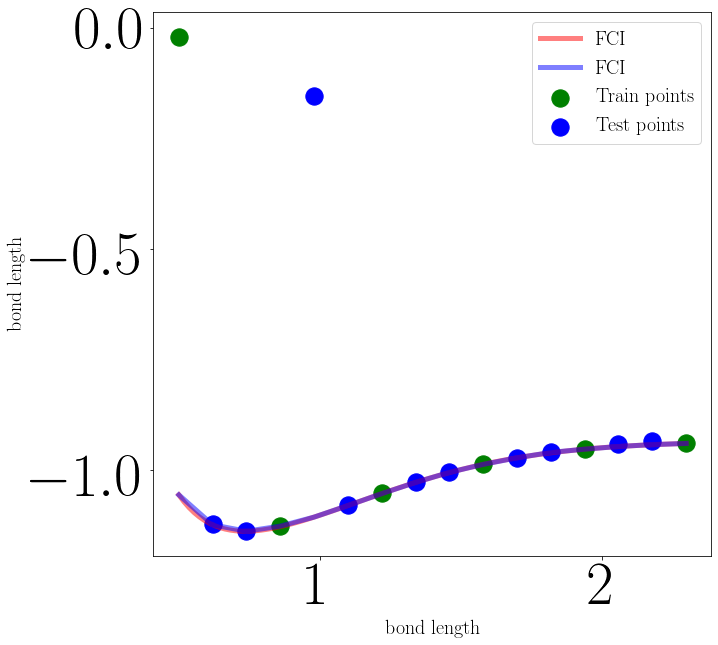

In [240]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(0.5,2.3,100),fcisfull,color="red",linewidth=5,alpha=0.5,label="FCI")
plt.plot(np.linspace(0.5,2.3,16),eners,color="blue",linewidth=5,alpha=0.5,label="FCI")

plt.scatter(bond_train, train_energies,s=300, color="green",label="Train points")
plt.scatter(bond_test, test_energies, s=300,color="blue",label="Test points")

#plt.scatter(bond_train, fcis_train,s=300, color="green",label="Train points")
#plt.scatter(bond_test, fcis_test, s=300,color="blue",label="Test points")
plt.xlabel("bond length",size=20)
plt.ylabel("bond length",size=20)
plt.legend(prop={"size":20})
#plt.savefig(fol+"energies.png")

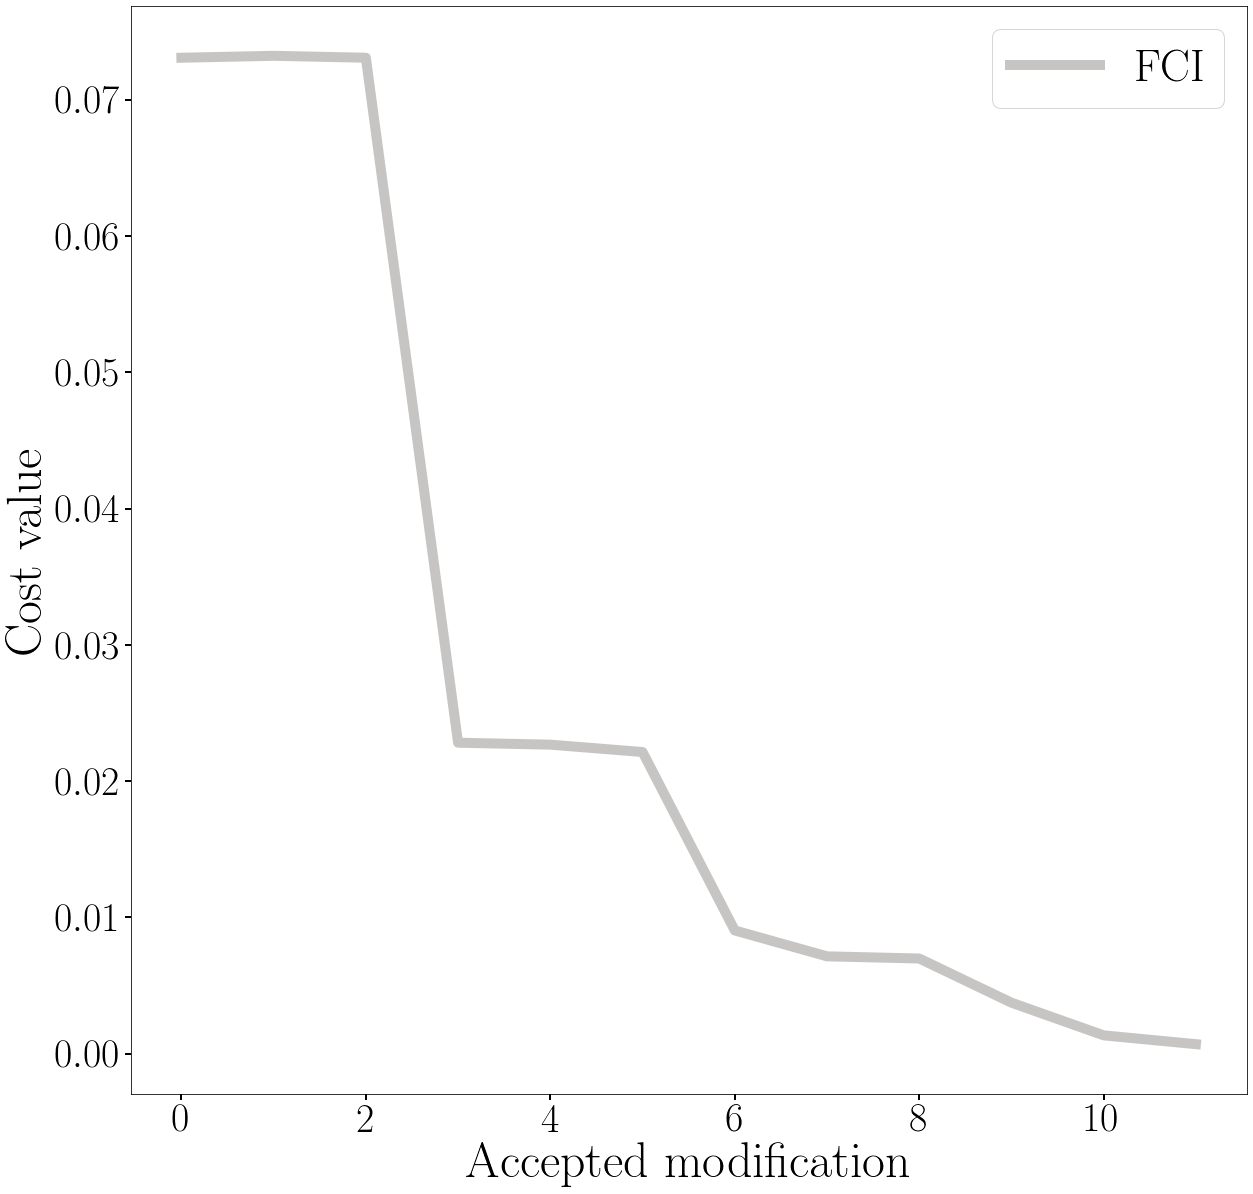

In [132]:

cost_value=[]
for k in list(auto_evaluator.evolution.values()):
    cost_value.append(k[1])
    
    

color1="#D79922"
color2="#4056A1"
color3="#F13C20"
color4="#5D001E"
color5="#8E8D8A"
import matplotlib

plt.style.use('results/plots/style.mplstyle')
matplotlib.rc("text",usetex=True)
plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.colors as colors
converter = colors.ColorConverter()
plt.rcParams.update({'font.size': 45})


plt.figure(figsize=(20,20))
plt.plot(cost_value,color=converter.to_rgb(color5),linewidth=10,alpha=0.5,label="FCI")
plt.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=40)
#plt.xticks([0.5,2.0,1.0,1.5,2.0,2.3])
plt.xlabel("Accepted modification")
plt.ylabel("Cost value")
plt.legend(prop={"size":45})
plt.savefig("cost_value.pdf",format="pdf")

Let's check fidelities in both train and test set

In [357]:
vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                        return_lower_bound=True)
VAnsCircuit, cuener, indexed_circuit, resolver, bestener = vqe_evaluator.evolution[vqe_evaluator.get_best_iteration()]

model = QNN(symbols=list(resolver.keys()), observable=vqe_handler.observable, batch_sizes=1)
model.compile(loss=EnergyLoss())


In [362]:
model.trainable_variables[0].assign(np.array(list(resolver.values())))

<tf.Variable 'UnreadVariable' shape=(20,) dtype=float32, numpy=
array([-1.529189  ,  1.6573579 , -1.9907739 , -0.55221456,  1.5579953 ,
       -3.0170643 ,  0.64609283,  3.5072904 , -3.3359911 ,  1.3399618 ,
        2.7758923 ,  0.89969695,  1.2831768 ,  4.8693476 ,  1.569377  ,
        1.5334276 , -4.7167826 , -1.6135931 , -2.8415253 ,  1.2119268 ],
      dtype=float32)>

In [368]:
things = auto_evaluator.evolution[auto_evaluator.get_best_iteration()]

In [370]:
things[1]

array(0.00070262, dtype=float32)

In [345]:
#### CHECK AT TRAIN FIDELITIES

fidelities = []
for k in range(len(auto_handler.qbatch)):
    input_state = cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
    fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
fidelities

[0.9998718421252814,
 0.9986230022092294,
 0.9998621884124173,
 0.9999003968033988,
 0.9999293491529342,
 0.9999216043656846]

In [338]:
#### CHECK AT TRAIN FIDELITIES

fidelities = []
for k in test_states:
    input_state = k#cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
    fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
fidelities

[0.9998136495901278,
 0.9998144388627288,
 0.1947643243483036,
 0.9998478559117874,
 0.9993205313323916,
 0.9989540413765526,
 0.999896116675036,
 0.998240526244957,
 0.9939913997627394,
 0.9919824445132158]

In [346]:
#### CHECK AT TRAIN FIDELITIES

fidelities = []
for k in train_states:
    input_state = k#cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
    fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
fidelities

[0.9998718421252814,
 0.9986230022092294,
 0.9998621884124173,
 0.9999003968033988,
 0.9999293491529342,
 0.9999216043656846]

In [349]:
st =np.dot(cirq.unitary(W),train_states[0])

In [281]:
b=0.5
problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., b))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
  
vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True)

In [371]:
def compute_energy(input_state, encoding, channel, decoding, observable):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.dot(np.conjugate(st),np.dot(observable,st))

channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
ene=compute_energy(cirq.unitary(VAnsCircuit)[:,0], cirq.unitary(W), channel, Wdagger, sum(vqe_handler.observable).matrix())   
print(ene,cuener)

(-0.02078744956019648+0j) -1.0551404


In [298]:
b=0.5
problem_config ={"problem" : "H2", "geometry": [('H', (0., 0., 0.)), ('H', (0., 0., b))], "multiplicity":1, "charge":0, "basis":"sto-3g"}
args={"n_qubits":8,"problem_config":problem_config, "load_displaying":False,"specific_folder_name":"4_bd_{}".format(b)}
vqe_evaluator = Evaluator(args,loading=True, path="../data-vans/data-in-paper-2marzo/")

vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                        return_lower_bound=True)
VAnsCircuit, cuener, indexed_circuit, resolver, bestener = vqe_evaluator.evolution[vqe_evaluator.get_best_iteration()]


In [325]:
def give_kronecker_of_list(lista):
    #lista=[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(3)]
    m=[]
    for ind,k in enumerate(lista):
        if ind == 0:
            m.append(k)
        else:
            m.append(np.kron(m[-1],k))
    return m[-1]

In [329]:
projector = give_kronecker_of_list([auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(auto_handler.nb)])
channel = np.kron(projector, np.eye(4))
compute_energy(cirq.unitary(VAnsCircuit)[:,0],cirq.unitary(W), channel, Wdagger, sum(vqe_handler.observable).matrix())

(-0.02078744956019648+0j)

In [302]:
compute_fidelity(cirq.unitary(VAnsCircuit)[:,0], cirq.unitary(W), channel, Wdagger)

(0.9998718421252814-0j)

In [235]:
test_fidelities = []
for k in test_states:
    input_state = k#cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qbits[k]).matrix() for k in range(2)]), np.eye(4)))
    test_fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
test_fidelities

[0.9992778551940966,
 0.9993209914318302,
 0.2012162184065344,
 0.9995786699686532,
 0.9992239999456392,
 0.9989040415027036,
 0.9999258297786662,
 0.9982705965581322,
 0.9945187972746974,
 0.991606443074509]

In [134]:
train_fidelities = []
for k in train_states:
    input_state = k#cirq.unitary(auto_handler.qbatch[k])[:,0]
    channel = (np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))
    train_fidelities.append(np.real(compute_fidelity(input_state, cirq.unitary(W), channel, Wdagger)))
train_fidelities

[0.9986425207759182,
 0.9969203743729877,
 0.999578609482883,
 0.9997422196036124,
 0.9993909888731102,
 0.9987620589812815]

In [ ]:
channel = np.eye(2**len(auto_handler.qubits)) - (1/auto_handler.nb)*(np.kron(np.kron(*[auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(2)]), np.eye(4)))

test_fidelities = []
for state in test_states:
    test_fidelities.append(compute_fidelity(state, W, channel, Wdagger))
    
train_fidelities = []
for state in train_states:
    train_fidelities.append(compute_fidelity(state, W, channel, Wdagger))

In [ ]:
import os 
fol="results/autoencoder/H2/"
os.makedirs(fol,exist_ok=True)
sts=["fcis_train", "fcis_test", "bond_train","bond_test", "bonds", "test_fidelities", "train_fidelities","fcisfull"]
fis=[fcis_train, fcis_test, bond_train, bond_test,np.linspace(0.5,2.3,16), test_fidelities, train_fidelities,fcisfull]
for strfi, thi in zip(sts, fis):
    np.save(fol+strfi,thi)

In [ ]:
bonds=np.linspace(0.5,2.3,16)
plt.figure(figsize=(10,10))
plt.plot(bonds,np.ones(len(bonds)),color="black",alpha=0.5,label="1")
plt.scatter(bond_train, train_fidelities, color="red",label="Train points")
plt.scatter(bond_test, test_fidelities, color="green",label="Test points")
plt.xlabel("bond length",size=20)
plt.ylabel("bond length",size=20)
plt.legend(prop={"size":20})
plt.savefig("fidelities.png")